In [4]:
#limpio la memoria
rm(list=ls())
gc()

#cargo librerias
library("data.table")
library("ROCR")
library("rpart")
library("rpart.plot")
library("caret")
library("parallel")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,494926,26.5,1093184,58.4,641780,34.3
Vcells,946983,7.3,8388608,64.0,1753993,13.4


Warning message:
“package ‘data.table’ was built under R version 3.6.3”
Warning message:
“package ‘ROCR’ was built under R version 3.6.3”
Warning message:
“package ‘rpart’ was built under R version 3.6.3”
Warning message:
“package ‘caret’ was built under R version 3.6.3”
Loading required package: lattice

Warning message:
“package ‘lattice’ was built under R version 3.6.3”
Loading required package: ggplot2



In [22]:

#Parametros entrada

#kcarpeta_datasets    <- "../input/laboratorio-de-implementacion-i-2021/"   #KAGGLE
kcarpeta_datasets    <- "./"                          #VM o Ubuntu

#Archivo con datos etiquetados para entrenamiento
karchivo_entrada      <-  paste0(kcarpeta_datasets, "2Universidades.csv")

#Formato para submit en Kaggle
#karchivo_score      <-  "../input/uamds2020ldi1f1/Sample_201910_Fase_I.txt"

#Separador de campos en archivos
kcampos_separador     <-  "\t"

#Campo que identifica las muestras
kcampo_id             <-  "ID"

#Campo que contiene la clase a estimar
kclase_nomcampo       <-  "Universidad"

#Valor de interés
kclase_valor_positivo <-  "Austral"

#Campos a borrar para el entrenamiento
kcampos_a_borrar      <-  c(kcampo_id,"Timestamp")

#Identificación del modelo
kmodelo               <-  "02-RPART"

semilla <- 0

#Establezco semilla aleatoria
set.seed(semilla)

qfolds<-3


In [23]:
#cargo los datos
dt <- fread(karchivo_entrada, sep = ",")


dt[,Universidad:=as.integer(dt$Universidad == 'Austral')]

for (j in which(sapply(dt, class)=='character')) set(dt, i=NULL, j=j, value=as.factor(dt[[j]]))

dt[is.na(dt)] <- -1

#Para hacer pruebas rapidas puedo reducir el dataset a una fraccion
#subsample <- sample(1:nrow(dataset), .1 * nrow(dataset))
#dataset <- dataset[subsample,]

In [24]:
#Limpio campos a borrar
dt[ ,  (kcampos_a_borrar) := NULL    ] 

In [25]:
#------------------------------------------------------------------------------
#funcion para particionar, es la que Andres reemplaza con caret

particionar  <- function( data, division, agrupa="", campo="fold", start=1, seed=NA )
{
  if( !is.na( seed)  )   set.seed( seed )

  bloque  <- unlist( mapply(  function(x,y) { rep( y, x ) }, division, seq( from=start, length.out=length(division) )  ) )

  data[ , (campo) :=  sample( rep( bloque, ceiling(.N/length(bloque))) )[1:.N],
           by= agrupa ]
}
#------------------------------------------------------------------------------

In [29]:
ArbolSimple  <- function( fold_test, data)
{
    #genero el modelo
    modelo  <- rpart("Universidad ~ .", 
                   data= data[ fold != fold_test, ],
                   maxdepth = 10,
                   minbucket = 3,
                   minsplit = 10,
                   xval= 0)

    prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)
    
    #aplico el modelo a los datos de testing, fold==2
    prediccion  <- predict( modelo, data[ fold==fold_test, ])


    #Calculo las metricas
    pred <- prediction(prediccion, data[ fold==fold_test,"Universidad" ])

    #Calculo las metricas
    perf <- performance(pred, measure = "tpr", x.measure = "fpr")

    #Grafico la ROC
    plot(perf, col=rainbow(10))

    #Determino AUC
    print(unlist(performance( pred,"auc")@y.values))
  return(     unlist(performance( pred,"auc")@y.values)     )
}

In [30]:
divi  <- rep( 1, qfolds )
particionar( dt, divi, seed=semilla, agrupa="Universidad" )

Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call prp with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


[1] 0.7481618


Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call prp with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


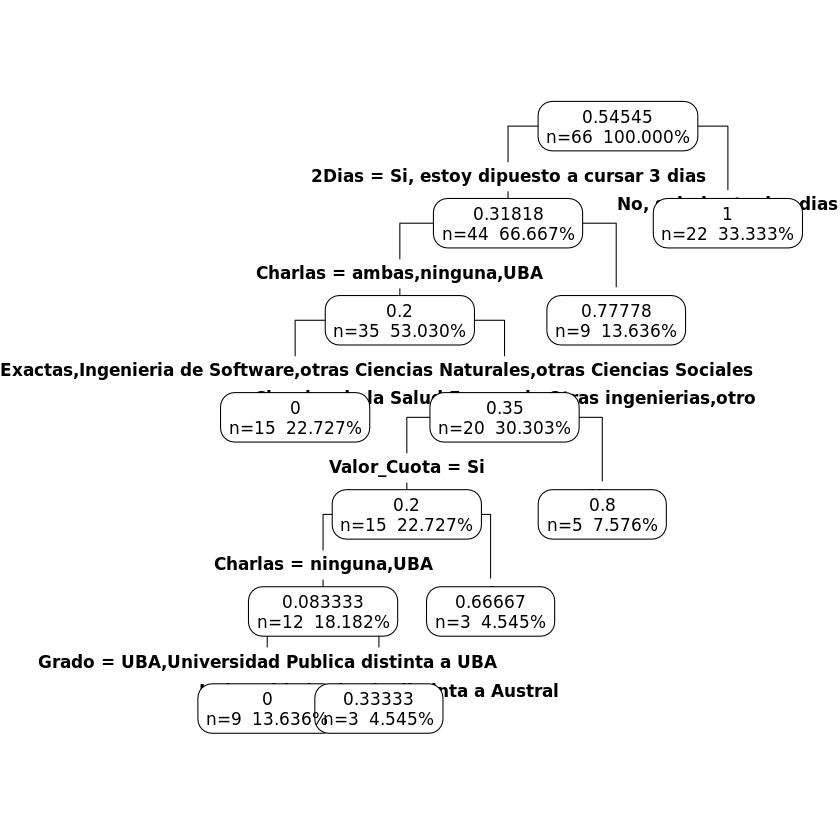

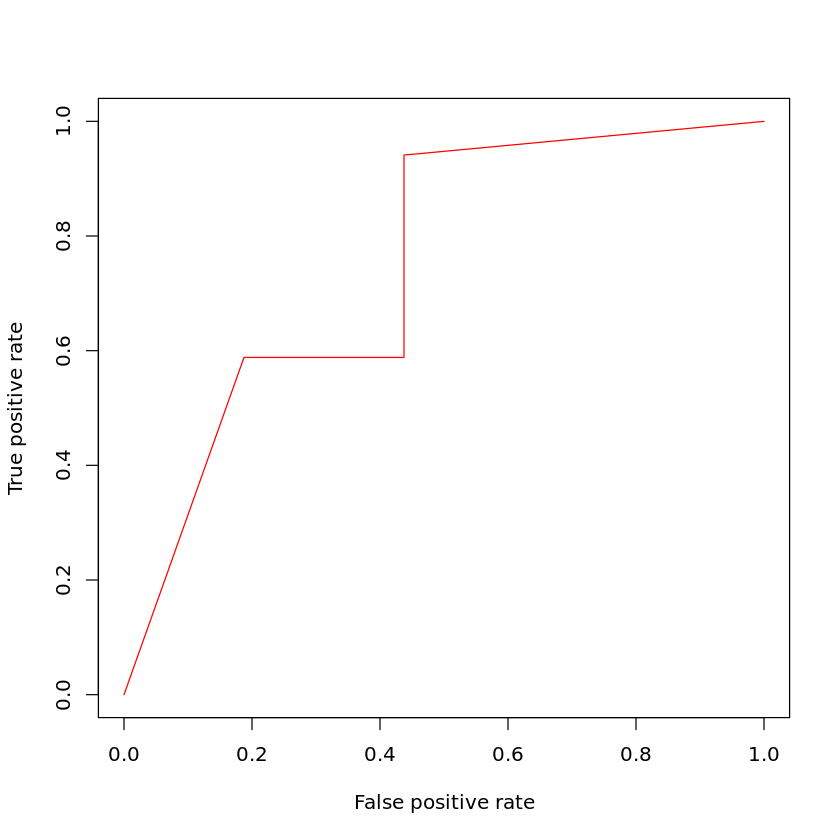

[1] 0.8240741


Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call prp with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


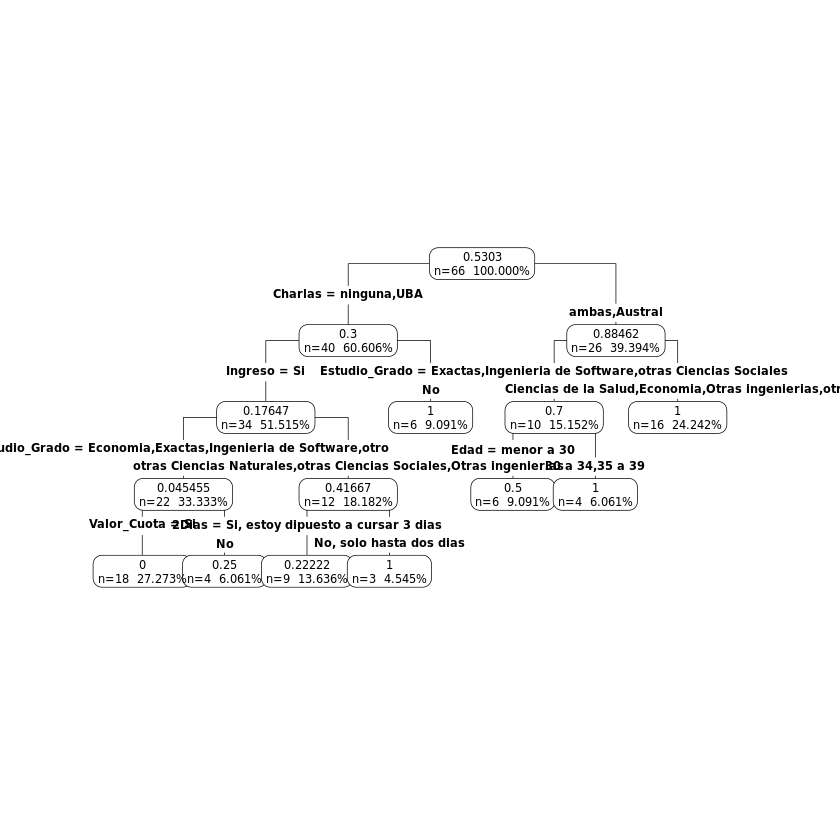

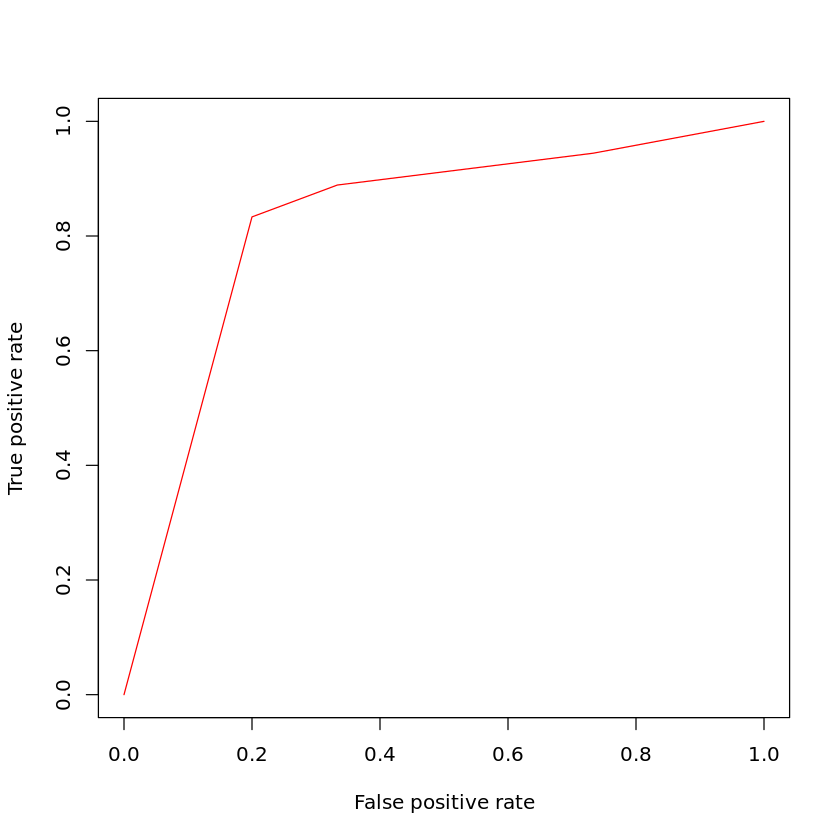

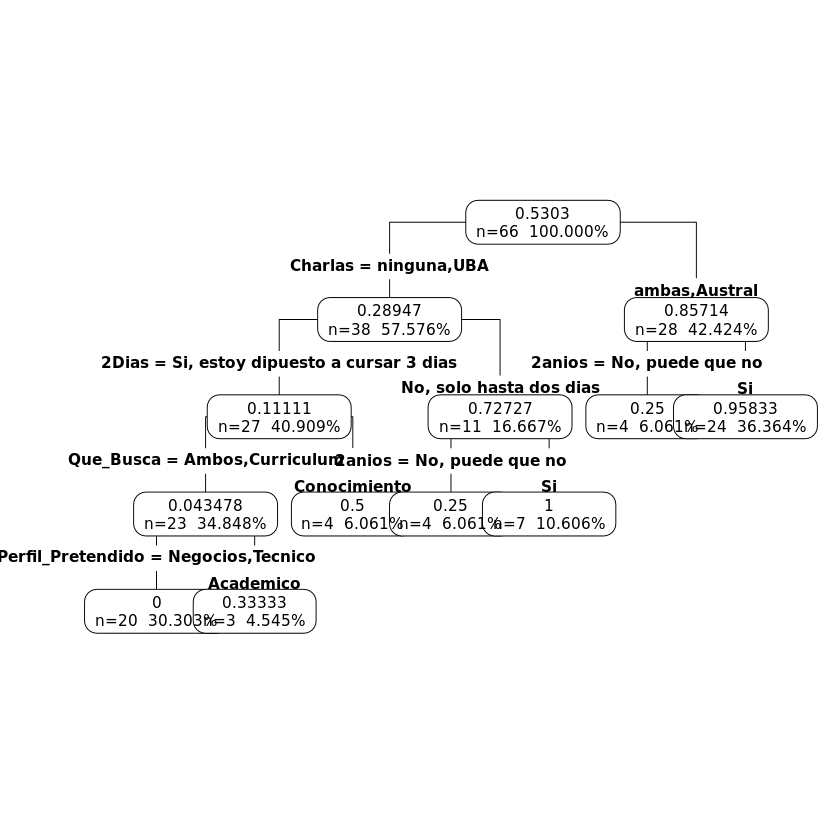

[1] 0.8259259
[1] "AUC Media: 0.799387254901961"


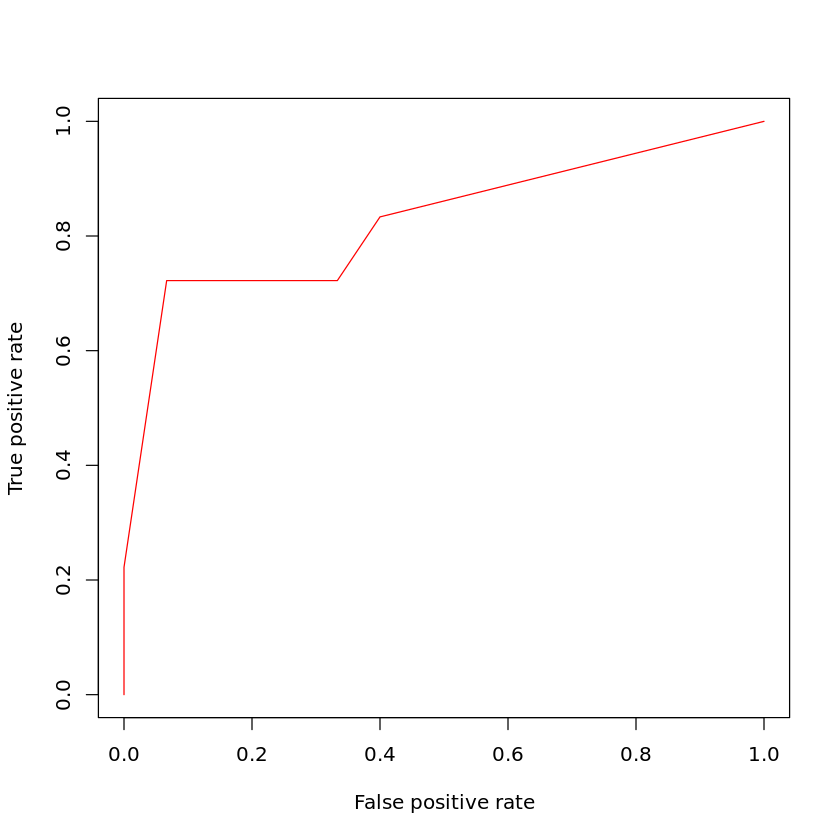

In [31]:
auc <- 0
for (i in 1:qfolds){

auc  <- auc + ArbolSimple(i, dt)   #se puede subir a 5 si posee Linux o Mac OS

}


#devuelvo la primer ganancia y el promedio
print(paste("AUC Media:",auc/qfolds))  #aqui normalizo la ganancia